### **1. Database Connection (PostgreSQL)**

In [33]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="healthcare_db-1",   # <-- doğru isim
    user="postgres",
    password="postgres123"
)

print("db connected")

db connected


### **2. Monthly Visit Trend (Last 15 Years)**

- Track how total encounters (visits) change over time
- Compare total visits vs. unique patients per month
This helps identify growth trends and repeat-visit behavior.

In [34]:
query = """
SELECT 
  DATE_TRUNC('month', "START") AS month,
  COUNT(*) AS total_visits,
  COUNT(DISTINCT "PATIENT") AS unique_patients
FROM encounters
WHERE "START" >= CURRENT_DATE - INTERVAL '15 years'
GROUP BY month
ORDER BY month;
"""

df_trend = pd.read_sql_query(query, conn)
df_trend.head(10)


C:\Users\nezih\AppData\Local\Temp\ipykernel_7500\1632159382.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_trend = pd.read_sql_query(query, conn)


,month,total_visits,unique_patients
0,2011-02-01 00:00:00-08:00,2,2
1,2011-03-01 00:00:00-08:00,4,3
2,2011-04-01 00:00:00-07:00,4,4
3,2011-05-01 00:00:00-07:00,7,5
4,2011-06-01 00:00:00-07:00,3,3
5,2011-07-01 00:00:00-07:00,2,1
6,2011-08-01 00:00:00-07:00,2,2
7,2011-09-01 00:00:00-07:00,5,3
8,2011-10-01 00:00:00-07:00,2,2
9,2011-11-01 00:00:00-07:00,2,1


### **3. Datetime Cleanup (Timezone Handling)**

The "month" column returned from PostgreSQL is timezone-aware (tz-aware).
For clean plotting and sorting, we convert it to UTC and then remove timezone info.

In [8]:
df_trend["month"] = pd.to_datetime(df_trend["month"], utc=True).dt.tz_convert(None)
df_trend = df_trend.sort_values("month")
df_trend.head()

,month,total_visits,unique_patients
0,2011-02-01 08:00:00,2,2
1,2011-03-01 08:00:00,4,3
2,2011-04-01 07:00:00,4,4
3,2011-05-01 07:00:00,7,5
4,2011-06-01 07:00:00,3,3


### **4. Visualization: Monthly Total Visits Trend**

This line chart shows overall hospital utilization over time, helping identify growth patterns and demand fluctuations.

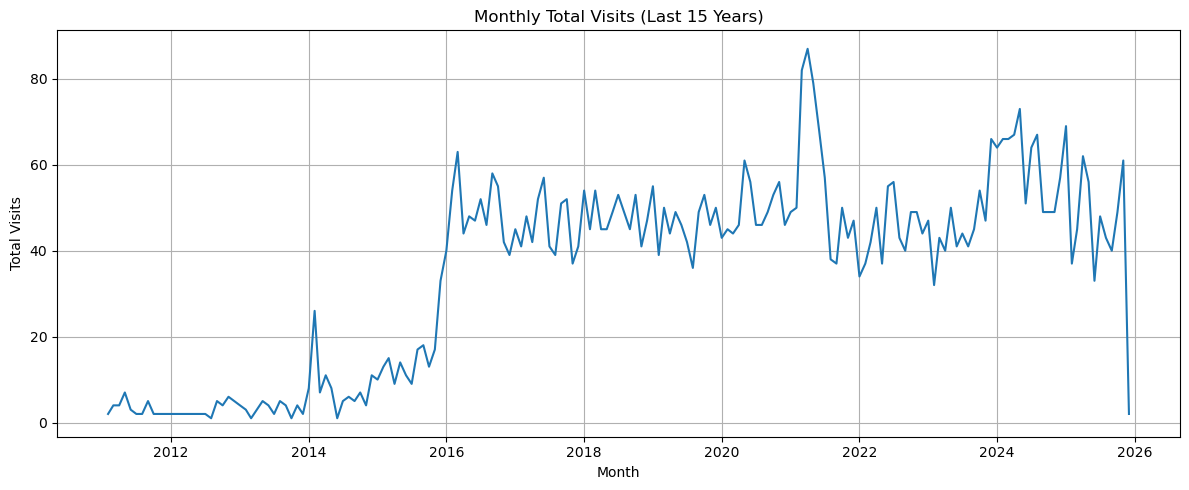

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_trend["month"], df_trend["total_visits"])
plt.title("Monthly Total Visits (Last 15 Years)")
plt.xlabel("Month")
plt.ylabel("Total Visits")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\healthcare-patient-visit-analysis\images\monthly_total_visits_last_15_years.png", 
            dpi=300, 
            bbox_inches="tight")
plt.show()


### **5. Visualization: Total Visits vs Unique Patients**

Comparing total visits against unique patients highlights repeat-visit behavior.
If total visits grow faster than unique patients, it suggests increased follow-ups or chronic care management among existing patients.

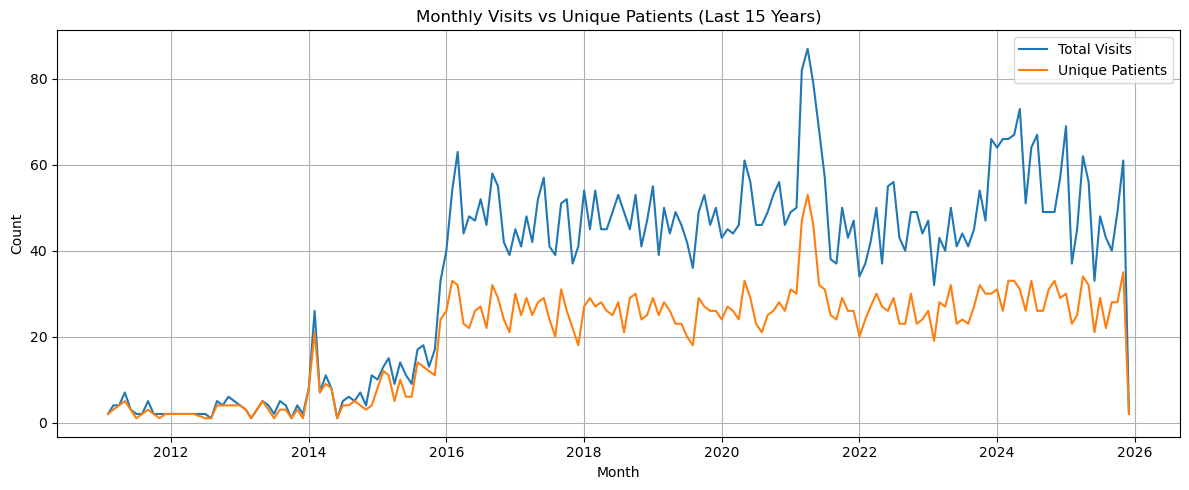

In [37]:
plt.figure(figsize=(12,5))
plt.plot(df_trend["month"], df_trend["total_visits"], label="Total Visits")
plt.plot(df_trend["month"], df_trend["unique_patients"], label="Unique Patients")
plt.title("Monthly Visits vs Unique Patients (Last 15 Years)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\healthcare-patient-visit-analysis\images\monthly_visits_vs_unique_patients.png",
            dpi=300,
            bbox_inches="tight")
plt.show()


### **6. Service Utilization: Visits by Encounter Class**

This section summarizes hospital utilization by service type (encounter class), such as ambulatory, outpatient, emergency, and inpatient.
It supports operational planning and resource allocation.

In [13]:
query = """
SELECT
    "ENCOUNTERCLASS" AS encounterclass,
    COUNT(*) AS total_visits
FROM encounters
GROUP BY "ENCOUNTERCLASS"
ORDER BY total_visits DESC;
"""

df_services = pd.read_sql_query(query, conn)
df_services


C:\Users\nezih\AppData\Local\Temp\ipykernel_7500\2825279362.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_services = pd.read_sql_query(query, conn)


,encounterclass,total_visits
0,ambulatory,3876
1,wellness,1316
2,outpatient,996
3,urgentcare,426
4,emergency,334
5,inpatient,81
6,virtual,35
7,snf,16
8,hospice,15


### **7. Visualization: Service-Level Visit Distribution**

This bar chart highlights which service types handle the highest visit volume.
It helps identify where operational capacity is most heavily utilized.

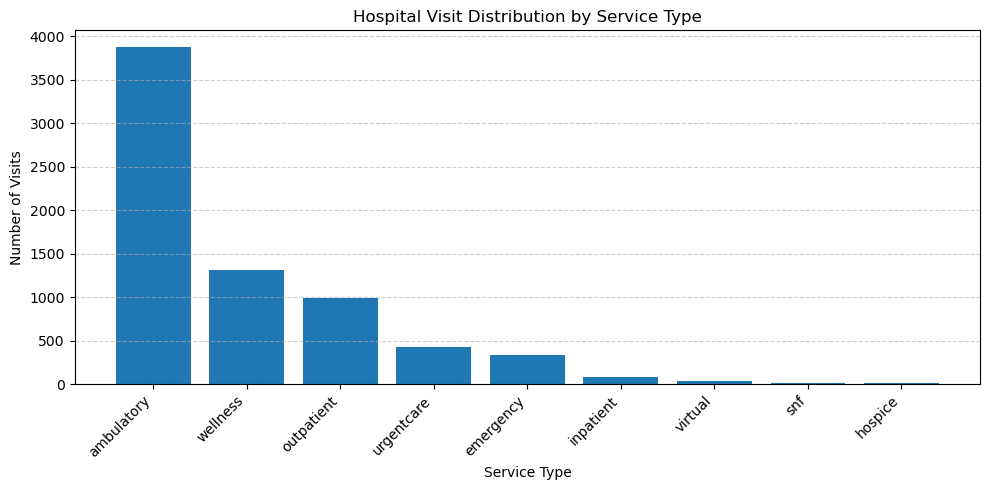

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.bar(
    df_services["encounterclass"],
    df_services["total_visits"]
)

plt.title("Hospital Visit Distribution by Service Type")
plt.xlabel("Service Type")
plt.ylabel("Number of Visits")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(r"C:\Users\nezih\healthcare-patient-visit-analysis\images\service_type_distribution.png",
            dpi=300,
            bbox_inches="tight")
plt.show()



### **8. Clinical Burden: Top 10 Most Frequent Conditions**

This section identifies the most frequently recorded conditions in the dataset.
It provides a high-level view of clinical demand and common patient issues.

In [21]:
query = """
SELECT 
  "DESCRIPTION" AS condition,
  COUNT(*) AS frequency
FROM conditions
GROUP BY "DESCRIPTION"
ORDER BY frequency DESC
LIMIT 10;
"""

df_conditions = pd.read_sql_query(query, conn)
df_conditions


C:\Users\nezih\AppData\Local\Temp\ipykernel_7500\3955321224.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_conditions = pd.read_sql_query(query, conn)


,condition,frequency
0,Medication review due (situation),911
1,Stress (finding),373
2,Gingivitis (disorder),334
3,Full-time employment (finding),333
4,Part-time employment (finding),219
5,Limited social contact (finding),135
6,Viral sinusitis (disorder),134
7,Social isolation (finding),124
8,Not in labor force (finding),111
9,Gingival disease (disorder),104


### **9. Visualization: Top 10 Most Frequent Conditions**

This horizontal bar chart shows the most common conditions recorded in the dataset.
It helps summarize clinical demand and highlight recurring issues.

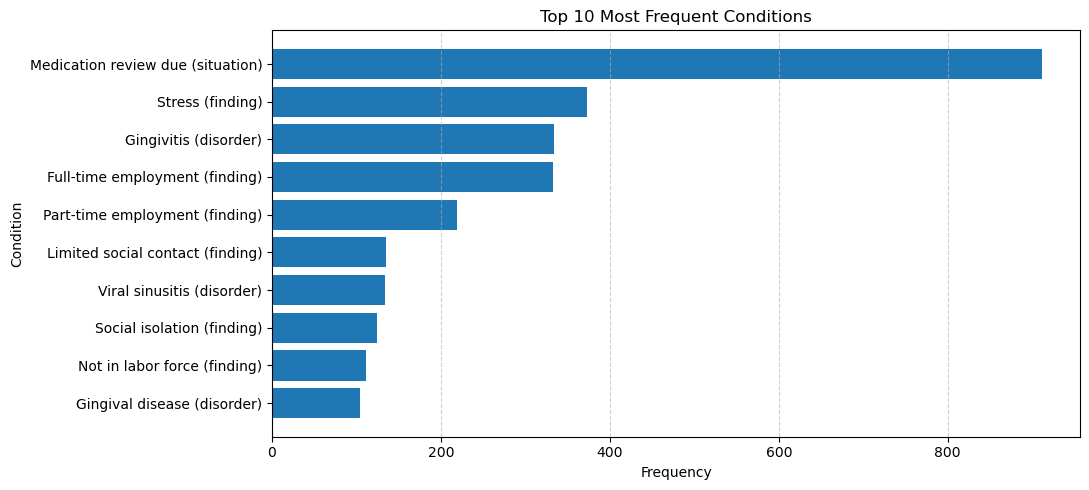

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,5))
plt.barh(df_conditions["condition"], df_conditions["frequency"])
plt.title("Top 10 Most Frequent Conditions")
plt.xlabel("Frequency")
plt.ylabel("Condition")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\healthcare-patient-visit-analysis\images\top_10_conditions.png",
            dpi=300,
            bbox_inches="tight")
plt.show()


### **10. Condition × Service Analysis (Multi-Table Join)**

 This analysis joins the conditions and encounters tables to determine which conditions are most frequently treated within each service type.
Business Purpose:
- Understand service-level clinical burden
- Identify which departments manage specific conditions
- Support resource planning and operational decisions

In [23]:
query = """
SELECT
    e."ENCOUNTERCLASS" AS service_type,
    c."DESCRIPTION" AS condition,
    COUNT(*) AS frequency
FROM conditions c
JOIN encounters e
    ON c."ENCOUNTER" = e."Id"
GROUP BY e."ENCOUNTERCLASS", c."DESCRIPTION"
ORDER BY frequency DESC
LIMIT 15;
"""

df_cond_service = pd.read_sql_query(query, conn)
df_cond_service


C:\Users\nezih\AppData\Local\Temp\ipykernel_7500\1041630660.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cond_service = pd.read_sql_query(query, conn)


,service_type,condition,frequency
0,wellness,Medication review due (situation),488
1,outpatient,Medication review due (situation),212
2,wellness,Stress (finding),207
3,wellness,Gingivitis (disorder),192
4,wellness,Full-time employment (finding),188
5,urgentcare,Medication review due (situation),181
6,ambulatory,Viral sinusitis (disorder),134
7,wellness,Part-time employment (finding),115
8,ambulatory,Gingival disease (disorder),104
9,outpatient,Gingivitis (disorder),88


### **11. Focus the Analysis on High-Volume Service Types**

To keep the visualization readable and decision-oriented, we focus on the most common service types (high utilization).
This allows clearer comparison of top conditions per service.

In [24]:
top_services = ["ambulatory", "wellness", "outpatient"]

df_top = df_cond_service[
    df_cond_service["service_type"].isin(top_services)
]
df_top


,service_type,condition,frequency
0,wellness,Medication review due (situation),488
1,outpatient,Medication review due (situation),212
2,wellness,Stress (finding),207
3,wellness,Gingivitis (disorder),192
4,wellness,Full-time employment (finding),188
6,ambulatory,Viral sinusitis (disorder),134
7,wellness,Part-time employment (finding),115
8,ambulatory,Gingival disease (disorder),104
9,outpatient,Gingivitis (disorder),88
10,outpatient,Stress (finding),85


### **12. Visualization: Top Conditions by Service Type**

This chart compares the most frequent conditions across selected high-volume service types (e.g., ambulatory, wellness, outpatient).
It helps identify how clinical demand differs by service line.

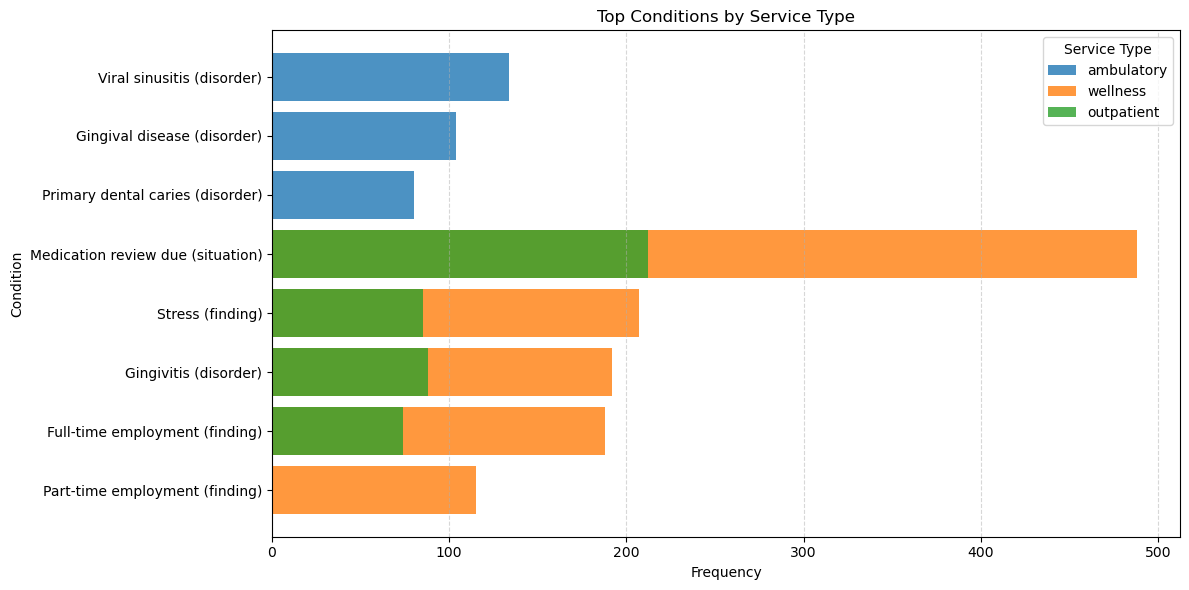

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for service in top_services:
    subset = df_top[df_top["service_type"] == service].head(5)
    plt.barh(
        subset["condition"],
        subset["frequency"],
        label=service,
        alpha=0.8
    )

plt.title("Top Conditions by Service Type")
plt.xlabel("Frequency")
plt.ylabel("Condition")
plt.legend(title="Service Type")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(r"C:\Users\nezih\healthcare-patient-visit-analysis\images\top_conditions_by_service_type.png",
            dpi=300,
            bbox_inches="tight")
plt.show()
